In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

resultsPath = Path("../results/MPI_8.csv")


In [8]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["messageSize"] = dataFrame["messageSize"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["numIterations"] = dataFrame["numIterations"].astype(int)
dataFrame["totalTime"] = dataFrame["totalTime"].astype(float)
dataFrame["avgRoundTrip"] = dataFrame["avgRoundTrip"].astype(float)
dataFrame["bandwidth"] = dataFrame["bandwidth"].astype(float)

print("Rows:", len(dataFrame))
print("Modes:", dataFrame["mode"].unique())
print("Message sizes:", sorted(dataFrame["messageSize"].unique()))
dataFrame.head()

Rows: 120
Modes: ['separate' 'sendrecv' 'isend_irecv']
Message sizes: [1, 16, 1024, 16384, 65536, 262144, 1048576, 4194304]


,testType,messageSize,numProcesses,mode,numIterations,totalTime,avgRoundTrip,bandwidth,runIndex,mpiEnv
0,MPI_8,1,2,separate,20000,0.009785,4.890000e-07,4087849.521,1,SLURM_NTASKS=2;JOBID=19515
1,MPI_8,1,2,separate,20000,0.011538,5.770000e-07,3466688.160,2,SLURM_NTASKS=2;JOBID=19516
2,MPI_8,1,2,separate,20000,0.011806,5.900000e-07,3388149.355,4,SLURM_NTASKS=2;JOBID=19518
3,MPI_8,1,2,separate,20000,0.011780,5.890000e-07,3395503.877,3,SLURM_NTASKS=2;JOBID=19517
4,MPI_8,1,2,separate,20000,0.011754,5.880000e-07,3402976.669,5,SLURM_NTASKS=2;JOBID=19519


In [9]:
grouped = dataFrame.groupby(["mode","messageSize","numProcesses"], as_index=False).agg(
    medianTotal=("totalTime","median"),
    medianRound=("avgRoundTrip","median"),
    medianBandwidth=("bandwidth","median"),
    stdTotal=("totalTime","std"),
    count=("totalTime","count")
)
grouped["stdTotal"] = grouped["stdTotal"].fillna(0.0)
grouped = grouped.sort_values(["mode","messageSize"]).reset_index(drop=True)
grouped.head(12)

,mode,messageSize,numProcesses,medianTotal,medianRound,medianBandwidth,stdTotal,count
0,isend_irecv,1,2,0.008262,4.130000e-07,4.841478e+06,0.000983,5
1,isend_irecv,16,2,0.009608,4.800000e-07,6.661100e+07,0.001184,5
2,isend_irecv,1024,2,0.004309,8.620000e-07,2.376444e+09,0.000054,5
3,isend_irecv,16384,2,0.011004,5.502000e-06,5.955641e+09,0.000230,5
4,isend_irecv,65536,2,0.024825,1.241200e-05,1.055984e+10,0.000624,5
5,isend_irecv,262144,2,0.026967,5.393300e-05,9.721086e+09,0.000119,5
6,isend_irecv,1048576,2,0.041827,2.091330e-04,1.002782e+10,0.002967,5
7,isend_irecv,4194304,2,0.084259,1.685170e-03,4.977900e+09,0.007546,5
8,sendrecv,1,2,0.007348,3.670000e-07,5.443965e+06,0.000439,5
9,sendrecv,16,2,0.007299,3.650000e-07,8.768833e+07,0.003600,5


In [10]:
speedupRows = []
for ms, sub in grouped.groupby("messageSize"):
    baseRow = sub[(sub["mode"]=="separate")]
    if baseRow.empty:
        continue
    baseTime = float(baseRow["medianTotal"].values[0])
    for _, row in sub.iterrows():
        speedup = baseTime / row["medianTotal"] if row["medianTotal"] > 0 else np.nan
        speedupRows.append({
            "messageSize": ms,
            "mode": row["mode"],
            "medianTotal": row["medianTotal"],
            "medianRound": row["medianRound"],
            "medianBandwidth": row["medianBandwidth"],
            "speedup": speedup
        })

speedupFrame = pd.DataFrame(speedupRows)
speedupFrame.head()


,messageSize,mode,medianTotal,medianRound,medianBandwidth,speedup
0,1,isend_irecv,0.008262,4.130000e-07,4.841478e+06,1.422658
1,1,sendrecv,0.007348,3.670000e-07,5.443965e+06,1.599619
2,1,separate,0.011754,5.880000e-07,3.402977e+06,1.000000
3,16,isend_irecv,0.009608,4.800000e-07,6.661100e+07,1.206286
4,16,sendrecv,0.007299,3.650000e-07,8.768833e+07,1.587889


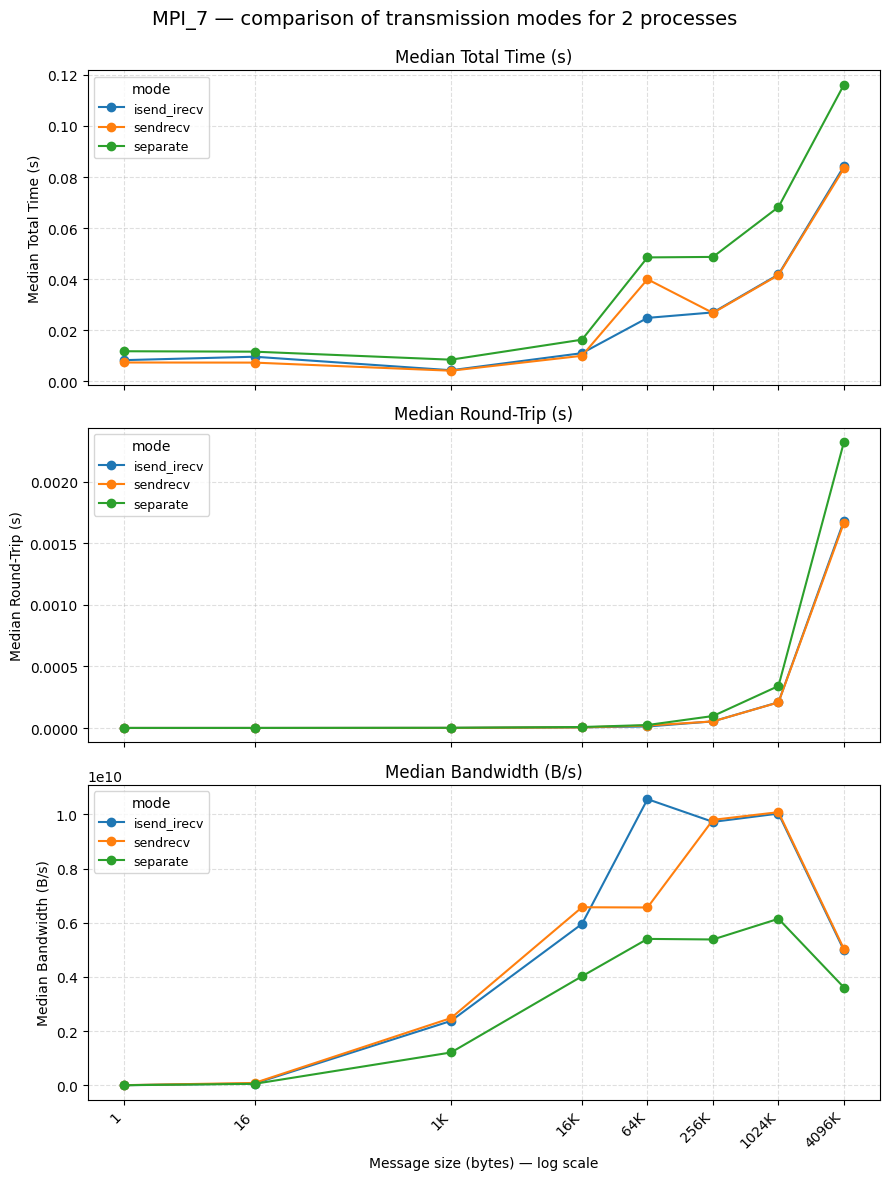

In [11]:
modes = sorted(grouped["mode"].unique())
metrics = ["medianTotal", "medianRound", "medianBandwidth"]
metricLabels = {"medianTotal":"Median Total Time (s)",
                "medianRound":"Median Round-Trip (s)",
                "medianBandwidth":"Median Bandwidth (B/s)"}

targetNumProcesses = 2
if targetNumProcesses not in grouped["numProcesses"].unique():
    print(f"Warning: there are no results for numProcesses={targetNumProcesses} in 'grouped'. Check your data.")
    
messageSizes = sorted(grouped["messageSize"].unique())

fig, axes = plt.subplots(len(metrics), 1, figsize=(9, 4 * len(metrics)), sharex=True)

if len(metrics) == 1:
    axes = [axes]

for rowIdx, metric in enumerate(metrics):
    ax = axes[rowIdx]
    for modeVal in modes:
        sub = grouped[(grouped["mode"] == modeVal) & (grouped["numProcesses"] == targetNumProcesses)].sort_values("messageSize")
        if sub.empty:
            continue
        x = sub["messageSize"].values
        y = sub[metric].values
        label = f"{modeVal}"
        ax.plot(x, y, marker='o', linestyle='-', label=label)

    ax.set_xscale('log', base=2)
    ax.set_title(metricLabels[metric])
    ax.set_ylabel(metricLabels[metric])
    ax.grid(True, which='both', linestyle='--', alpha=0.4)
    ax.legend(title="mode", fontsize=9)

axes[-1].set_xlabel("Message size (bytes) — log scale")
xticks = messageSizes
maxTicks = 10
if len(xticks) > maxTicks:
    indices = np.linspace(0, len(xticks) - 1, maxTicks, dtype=int)
    xticks = [xticks[i] for i in indices]

axes[-1].set_xticks(xticks)
def humanLabel(n):
    if n >= 1024:
        if n % 1024 == 0:
            return f"{n//1024}K"
        else:
            return f"{n/1024:.1f}K"
    return str(n)
axes[-1].set_xticklabels([humanLabel(v) for v in xticks], rotation=45, ha='right')

plt.tight_layout(rect=[0,0,1,0.96])
plt.suptitle("MPI_7 — comparison of transmission modes for 2 processes", fontsize=14)
plt.show()


In [12]:
display(speedupFrame.pivot(index="messageSize", columns="mode", values="speedup"))


mode,isend_irecv,sendrecv,separate
messageSize,,,
1,1.422658,1.599619,1.0
16,1.206286,1.587889,1.0
1024,1.960548,2.047504,1.0
16384,1.480098,1.632946,1.0
65536,1.954441,1.214615,1.0
262144,1.806171,1.820278,1.0
1048576,1.631745,1.640176,1.0
4194304,1.379129,1.393049,1.0
